#Sequencing Success: A Hands-On Workshop in Deep Learning for Sequence-to-Sequence Models
Moratuwa Engineering Research Conference 2023 (MERCon 2023) is the 9th international conference organized by the Engineering Research Unit at the University of Moratuwa. As part of MERCon 2023, we are hosting a Hands-On Workshop on Deep Learning for Sequence-to-Sequence Models. This workshop spans four hours and is divided into four one-hour sessions, covering the following topics:
- Introduction to Sequence-to-Sequence Learning
- Sequence-to-Sequence Learning with Recurrent Neural Networks (RNNs)
- Sequence-to-Sequence Learning with Encoder-Decoder Models
- Sequence-to-Sequence Learning with Encoder-Decoder Models and Attention Mechanisms

This notebook is prepared for session **Sequence-to-Sequence Learning with Recurrent Neural Networks**.

All rights reserved.

Authors:
1.   Dr.T.Uthayasanker ([rtuthaya.lk](https://rtuthaya.lk))
2.   Mr.S.Braveenan

[For more information - MERCon 2023](https://mercon.uom.lk)

#A Simple Seq2Seq Problem 2: The reverse sentence problem
In this simple Seq2Seq problem, we are provided with a **parallel dataset** comprising two sentences, X (input) and y (output). In this scenario, the output sentence, y[i], is constructed by reversing the order of the words in the input sentence, X[i]. To illustrate, consider an example where the **input sentence X[i]** has a length of 6, such as:

X[i] = **he ate apple**

The corresponding **output sentence, y[i]**, would be:

y[i] = **apple ate he**

This problem serves as a foundational example of a Sequence-to-Sequence (Seq2Seq) task, where the objective is to learn to reverse sentences effectively.

In [ ]:
#@title Import Libraries
import random
import numpy as np
import matplotlib.pyplot as plt

from keras import Input
from keras.layers import RepeatVector, Dense, SimpleRNN, GRU, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import Sequential, Model

#Auxiliary functions

Certainly! Here's a more concise introduction to the key functions in the code snippet:
1. **generate_text_sequence(length, word_array)**: Generates a random text sequence of a given length using words from an array.
2. **one_hot_encode_text(text_sequence, word_array)**: Converts a text sequence into one-hot encoded vectors using a word array.
3. **one_hot_decode_text(encoded_seq, word_array)**: Decodes a one-hot encoded sequence back into its original text form.
4. **get_reversed_pairs(time_steps, word_array, verbose=False)**: Generates pairs of random sequences and their reversals, one-hot encodes them, and returns them for training.
5. **create_dataset(train_size, test_size, time_steps, word_array, verbose=False)**: Creates training and testing datasets by generating reversed pairs.
6. **train_test(model, X_train, y_train, X_test, y_test, epochs=100, verbose=0)**: Trains a neural network model, evaluates it, and returns the model and training history.
7. **visualize_history(history)**: Visualizes the training history, showing accuracy and loss over epochs.
8. **check_samples(model, X_test, y_test, word_array, num_samples=10)**: Checks the model's performance on a set of sample sequences from the testing data.

These functions collectively support the process of training and evaluating a neural network for a sentence reversal task.

In [ ]:
#@title Function to generate a text sequence
# generate sequence
def generate_text_sequence(length, word_array):
    word_sequence = [random.choice(word_array) for _ in range(length)]
    text_sequence = ' '.join(word_sequence)
    return text_sequence

In [ ]:
#@title Function to encode and decode text sequence
# one hot encode sequence
def one_hot_encode_text(text_sequence, word_array):
    encoding = []
    for word in text_sequence.split():
        vector = [0] * len(word_array)
        if word in word_array:
            vector[word_array.index(word)] = 1
        encoding.append(vector)
    return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode_text(encoded_seq, word_array):
    decoded_sequence = [word_array[np.argmax(vector)] for vector in encoded_seq]
    return ' '.join(decoded_sequence)

In [ ]:
#@title Function to generate reverse pair dataset
# create one reverse pair
def get_reversed_pairs(time_steps,word_array,verbose= False):
		# generate random sequence
		sequence_in = generate_text_sequence(time_steps, word_array)
		sequence_out = ' '.join(sequence_in.split()[::-1])

		# one hot encode
		X = one_hot_encode_text(sequence_in, word_array)
		y = one_hot_encode_text(sequence_out, word_array)
		# reshape as 3D
		X = X.reshape((1, X.shape[0], X.shape[1]))
		y = y.reshape((1, y.shape[0], y.shape[1]))

		if(verbose):
			print('\nSample X and y')
			print('\nIn raw format:')
			print('X[0]=%s, y[0]=%s' % (one_hot_decode_text(X[0], word_array), one_hot_decode_text(y[0], word_array)))
			print('\nIn one_hot_encoded format:')
			print('X[0]=%s' % (X[0]))
			print('y[0]=%s' % (y[0]))
		return X,y

# create final dataset
def create_dataset(train_size, test_size, time_steps,word_array, verbose= False):
		pairs = [get_reversed_pairs(time_steps,word_array) for _ in range(train_size)]
		pairs=np.array(pairs).squeeze()
		X_train = pairs[:,0]
		y_train = pairs[:,1]
		pairs = [get_reversed_pairs(time_steps,word_array) for _ in range(test_size)]
		pairs=np.array(pairs).squeeze()
		X_test = pairs[:,0]
		y_test = pairs[:,1]

		if(verbose):
			print('\nGenerated sequence datasets as follows')
			print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
			print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)

		return X_train, y_train, X_test, 	y_test

In [ ]:
#@title Function to train and evaluate model
def train_test(model, X_train, y_train , X_test, y_test, epochs=100, verbose=0):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    # train model
    print('training for ',epochs,' epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....')
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    return model, history.history

In [ ]:
#@title Function to visualize loss and accuracy
def visualize_history(history):
	# summarize history for accuracy
	plt.plot(history['accuracy'])
	plt.plot(history['val_accuracy'])
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history['loss'])
	plt.plot(history['val_loss'])
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

In [ ]:
#@title Function to check some examples
def check_samples(model, X_test, y_test, word_array, num_samples=10):
    sample_indices = random.sample(range(len(X_test)), num_samples)

    for id in sample_indices:
        X, y = X_test[id], y_test[id]
        X = np.expand_dims(X, axis=0)
        y = np.expand_dims(y, axis=0)
        yhat = model.predict(X, verbose=0)
        print(f"Input: {one_hot_decode_text(X[0], word_array)}, Expected: {one_hot_decode_text(y[0], word_array)}, Predicted: {one_hot_decode_text(yhat[0], word_array)} {np.array_equal(one_hot_decode_text(y[0], word_array), one_hot_decode_text(yhat[0], word_array))}")

#Create reverse sentence dataset


This code snippet is designed to generate a dataset for the **Reverse Sentence Task**. In this task, each data point consists of a sentence and its reversed counterpart. The essential parameters include the input sequence length (n_timesteps_in), the number of unique words (n_features), the size of the training dataset (train_size), and the size of the testing dataset (test_size).

The code accomplishes the following:
1. It generates a random sentence and its reversed version, one-hot encodes them, and optionally displays sample pairs of sentences to illustrate the dataset structure.
2. The code then creates training and testing datasets by generating pairs of random sentences and their reversals. The dataset sizes are determined by the parameters train_size and test_size.

This dataset is a crucial component for training and evaluating models for the **Reverse Sentence Task**, which is a common problem in natural language processing.

In [ ]:
word_array = ["apple", "banana", "cherry", "orange", "strawberry",
             "carrot", "broccoli", "potato", "tomato", "cucumber",
             "rose", "tulip", "daisy", "lily", "sunflower",
             "red", "blue", "green", "yellow", "purple",
             "Colombo", "London", "Paris", "Tokyo", "Sydney",
             "car", "bus", "bicycle", "train", "motorcycle",
             "guitar", "piano", "violin", "trumpet", "flute",
             "beach", "mountain", "park", "desert", "island",
             "book", "computer", "chair", "table", "lamp",
             "dog", "cat", "bird", "elephant", "lion"]

In [ ]:
#@title Generating dataset
# Default configuration parameters
n_timesteps_in = 6
n_features = len(word_array)
train_size = 20000
test_size = 200

# Generate random sequence using specified parameters
X, y = get_reversed_pairs(n_timesteps_in, word_array, verbose=True)

# Generate datasets using specified parameters
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in, word_array, verbose=True)


Sample X and y

In raw format:
X[0]=tulip broccoli train Tokyo beach blue, y[0]=blue beach Tokyo train broccoli tulip

In one_hot_encoded format:
X[0]=[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
y[0]=[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [

#1. Multi-Layer Perceptron network model

Model: "model_Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6, 128)            6528      
                                                                 
 dense_1 (Dense)             (None, 6, 64)             8256      
                                                                 
 dense_2 (Dense)             (None, 6, 50)             3250      
                                                                 
Total params: 18034 (70.45 KB)
Trainable params: 18034 (70.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


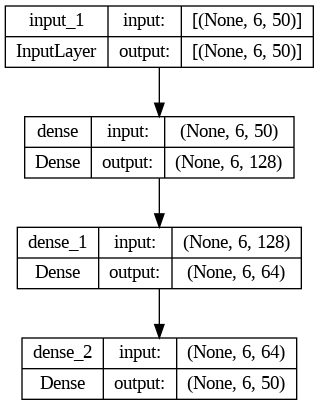

In [ ]:
#@title Create Multi-Layer Perceptron network model
numberOfPerceptrons=64
model_Multi_Layer_Perceptron = Sequential(name='model_Multi_Layer_Perceptron')
model_Multi_Layer_Perceptron.add(Input(shape=(n_timesteps_in, n_features)))
model_Multi_Layer_Perceptron.add(Dense(2*numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(n_features, activation='softmax'))

model_Multi_Layer_Perceptron.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Multi_Layer_Perceptron.summary()
plot_model(model_Multi_Layer_Perceptron,show_shapes=True)

In [ ]:
#@title Train and Evaluate Multi-Layer Perceptron network model
trained_model_mlp, history_mlp = train_test(model_Multi_Layer_Perceptron, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 5s - loss: 3.9176 - accuracy: 0.0213 - val_loss: 3.9160 - val_accuracy: 0.0198 - 5s/epoch - 10ms/step
Epoch 2/100
563/563 - 2s - loss: 3.9117 - accuracy: 0.0219 - val_loss: 3.9177 - val_accuracy: 0.0236 - 2s/epoch - 4ms/step
Epoch 3/100
563/563 - 4s - loss: 3.9101 - accuracy: 0.0233 - val_loss: 3.9187 - val_accuracy: 0.0206 - 4s/epoch - 6ms/step
Epoch 4/100
563/563 - 4s - loss: 3.9092 - accuracy: 0.0238 - val_loss: 3.9191 - val_accuracy: 0.0223 - 4s/epoch - 7ms/step
Epoch 5/100
563/563 - 3s - loss: 3.9086 - accuracy: 0.0238 - val_loss: 3.9196 - val_accuracy: 0.0235 - 3s/epoch - 6ms/step
Epoch 6/100
563/563 - 3s - loss: 3.9083 - accuracy: 0.0248 - val_loss: 3.9193 - val_accuracy: 0.0227 - 3s/epoch - 5ms/step
Epoch 7/100
563/563 - 3s - loss: 3.9079 - accuracy: 0.0252 - val_loss: 3.9199 - val_accuracy: 0.0227 - 3s/epoch - 6ms/step
Epoch 8/100
563/563 - 4s -

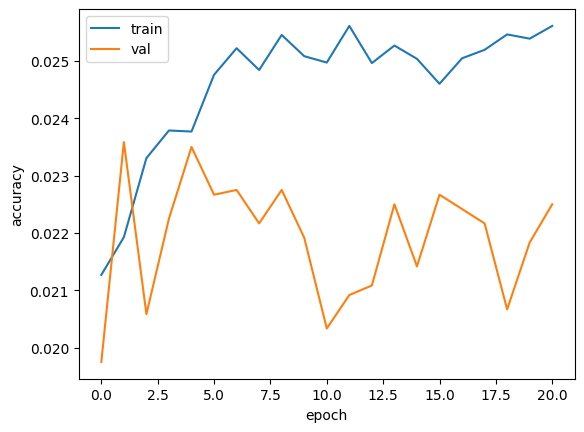

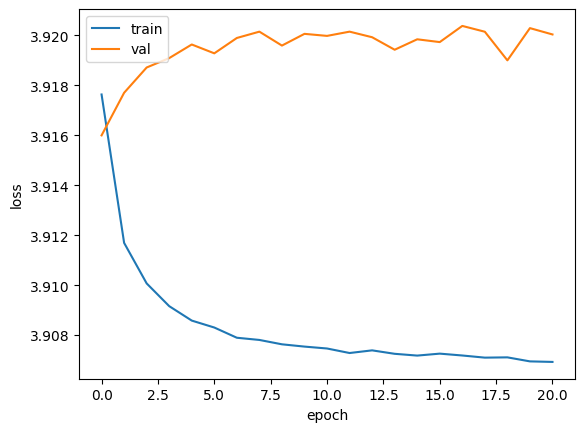

In [ ]:
#@title Visualize training and validation Multi-Layer Perceptron network model
visualize_history(history_mlp)

In [ ]:
#@title Check random samples Multi-Layer Perceptron network model
check_samples(trained_model_mlp, X_test, y_test, word_array, num_samples=10)

Input: computer motorcycle motorcycle banana blue yellow, Expected: yellow blue banana motorcycle motorcycle computer, Predicted: apple yellow yellow park piano motorcycle False
Input: computer Sydney violin lion car mountain, Expected: mountain car lion violin Sydney computer, Predicted: apple daisy green park elephant orange False
Input: yellow blue sunflower strawberry flute banana, Expected: banana flute strawberry sunflower blue yellow, Predicted: motorcycle piano broccoli strawberry park park False
Input: tulip chair strawberry piano sunflower strawberry, Expected: strawberry sunflower piano strawberry chair tulip, Predicted: daisy yellow strawberry blue broccoli strawberry False
Input: Paris piano island yellow bus computer, Expected: computer bus yellow island piano Paris, Predicted: flute blue Sydney motorcycle beach apple False
Input: park flute flute computer yellow motorcycle, Expected: motorcycle yellow computer flute flute park, Predicted: banana park park apple motorcycl

#2. Recurrent Neural Networks

#2.1. Simple Recurrent Neural Network model (RNN)

Model: "model_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6, 64)             7360      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 6, 64)             8256      
                                                                 
 time_distributed (TimeDist  (None, 6, 50)             3250      
 ributed)                                                        
                                                                 
Total params: 18866 (73.70 KB)
Trainable params: 18866 (73.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


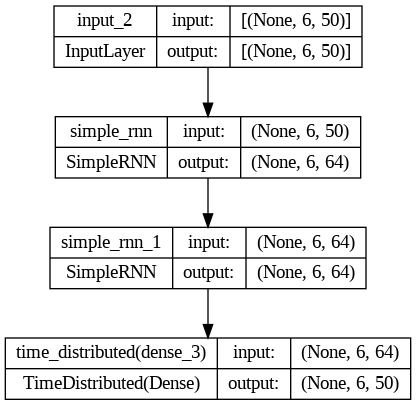

In [ ]:
#@title Create simple RNN model
numberOfUnits = 64
model_RNN = Sequential(name='model_RNN')
model_RNN.add(Input(shape=(n_timesteps_in, n_features)))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_RNN.summary()
plot_model(model_RNN, show_shapes=True)

In [ ]:
#@title Train and Evaluate simple RNN model
trained_model_rnn, history_rnn = train_test(model_RNN, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 5s - loss: 3.1196 - accuracy: 0.2656 - val_loss: 2.8325 - val_accuracy: 0.3253 - 5s/epoch - 9ms/step
Epoch 2/100
563/563 - 3s - loss: 2.7497 - accuracy: 0.3324 - val_loss: 2.7114 - val_accuracy: 0.3375 - 3s/epoch - 5ms/step
Epoch 3/100
563/563 - 4s - loss: 2.6702 - accuracy: 0.3384 - val_loss: 2.6658 - val_accuracy: 0.3403 - 4s/epoch - 6ms/step
Epoch 4/100
563/563 - 3s - loss: 2.6332 - accuracy: 0.3408 - val_loss: 2.6427 - val_accuracy: 0.3417 - 3s/epoch - 5ms/step
Epoch 5/100
563/563 - 3s - loss: 2.6096 - accuracy: 0.3415 - val_loss: 2.6268 - val_accuracy: 0.3422 - 3s/epoch - 5ms/step
Epoch 6/100
563/563 - 3s - loss: 2.5937 - accuracy: 0.3423 - val_loss: 2.6196 - val_accuracy: 0.3421 - 3s/epoch - 5ms/step
Epoch 7/100
563/563 - 3s - loss: 2.5826 - accuracy: 0.3427 - val_loss: 2.6098 - val_accuracy: 0.3423 - 3s/epoch - 6ms/step
Epoch 8/100
563/563 - 3s - 

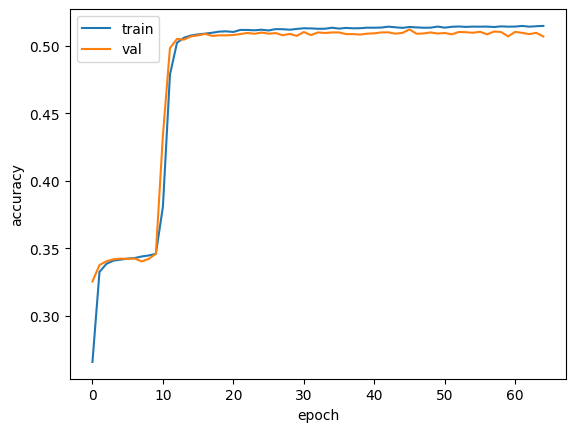

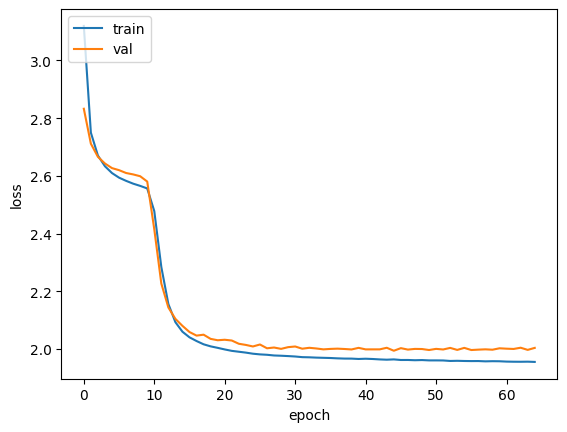

In [ ]:
#@title Visualize training and validation simple RNN model
visualize_history(history_rnn)

In [ ]:
#@title Check random samples simple RNN model
check_samples(trained_model_rnn, X_test, y_test, word_array, num_samples=10)

Input: green cucumber Colombo Tokyo cucumber table, Expected: table cucumber Tokyo Colombo cucumber green, Predicted: violin motorcycle chair Colombo cucumber green False
Input: cat mountain table car strawberry violin, Expected: violin strawberry car table mountain cat, Predicted: cherry motorcycle orange table mountain cat False
Input: strawberry broccoli blue lamp beach beach, Expected: beach beach lamp blue broccoli strawberry, Predicted: red strawberry tomato blue broccoli strawberry False
Input: strawberry rose mountain park lily book, Expected: book lily park mountain rose strawberry, Predicted: red strawberry lion mountain rose strawberry False
Input: book motorcycle trumpet lily lily daisy, Expected: daisy lily lily trumpet motorcycle book, Predicted: guitar Sydney Paris trumpet motorcycle book False
Input: daisy blue desert apple cherry desert, Expected: desert cherry apple desert blue daisy, Predicted: cat Sydney London desert blue daisy False
Input: green flute orange piano

#2.2. Gated Recurrent Units model (GRU)

Model: "model_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 64)             22272     
                                                                 
 gru_1 (GRU)                 (None, 6, 64)             24960     
                                                                 
 time_distributed_1 (TimeDi  (None, 6, 50)             3250      
 stributed)                                                      
                                                                 
Total params: 50482 (197.20 KB)
Trainable params: 50482 (197.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


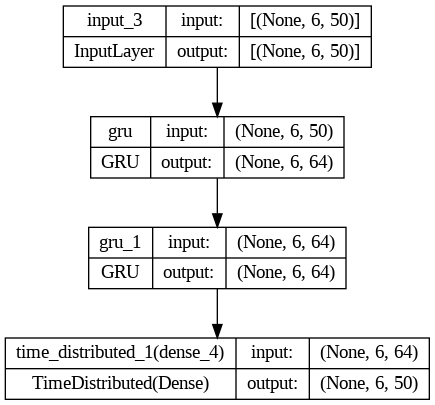

In [ ]:
#@title Create GRU model
numberOfUnits = 64
model_GRU = Sequential(name='model_GRU')
model_GRU.add(Input(shape=(n_timesteps_in, n_features)))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_GRU.summary()
plot_model(model_GRU, show_shapes=True)

In [ ]:
#@title Train and Evaluate GRU model
trained_model_gru, history_gru = train_test(model_GRU, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 11s - loss: 3.3098 - accuracy: 0.1410 - val_loss: 2.9867 - val_accuracy: 0.1819 - 11s/epoch - 20ms/step
Epoch 2/100
563/563 - 6s - loss: 2.8837 - accuracy: 0.1890 - val_loss: 2.8135 - val_accuracy: 0.2040 - 6s/epoch - 10ms/step
Epoch 3/100
563/563 - 6s - loss: 2.6982 - accuracy: 0.2497 - val_loss: 2.5630 - val_accuracy: 0.3288 - 6s/epoch - 10ms/step
Epoch 4/100
563/563 - 5s - loss: 2.3991 - accuracy: 0.3975 - val_loss: 2.2992 - val_accuracy: 0.4381 - 5s/epoch - 9ms/step
Epoch 5/100
563/563 - 6s - loss: 2.1962 - accuracy: 0.4686 - val_loss: 2.1548 - val_accuracy: 0.4780 - 6s/epoch - 11ms/step
Epoch 6/100
563/563 - 5s - loss: 2.0922 - accuracy: 0.4931 - val_loss: 2.0794 - val_accuracy: 0.4945 - 5s/epoch - 9ms/step
Epoch 7/100
563/563 - 6s - loss: 2.0381 - accuracy: 0.5031 - val_loss: 2.0366 - val_accuracy: 0.5024 - 6s/epoch - 11ms/step
Epoch 8/100
563/563 

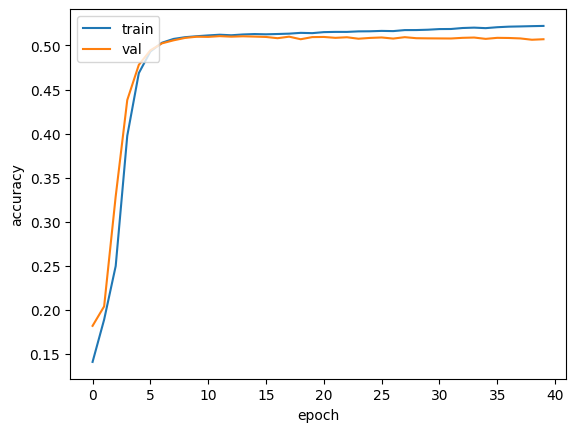

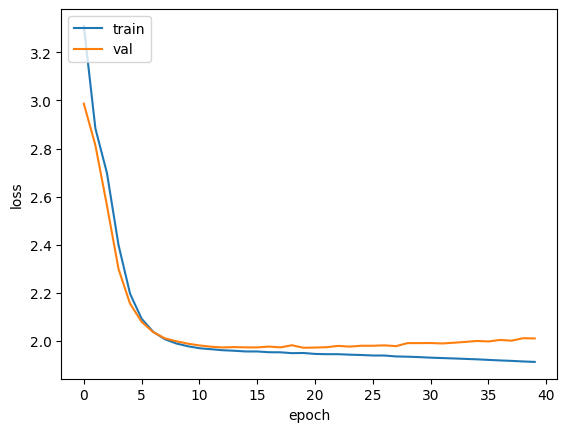

In [ ]:
#@title Visualize training and validation GRU model
visualize_history(history_gru)

In [ ]:
#@title Check random samples GRU model
check_samples(trained_model_gru, X_test, y_test, word_array, num_samples=10)

Input: motorcycle Sydney dog bird island strawberry, Expected: strawberry island bird dog Sydney motorcycle, Predicted: guitar yellow island dog Sydney motorcycle False
Input: tomato Paris bus Tokyo yellow Sydney, Expected: Sydney yellow Tokyo bus Paris tomato, Predicted: book Colombo cucumber bus Paris tomato False
Input: strawberry rose mountain park lily book, Expected: book lily park mountain rose strawberry, Predicted: banana strawberry green mountain rose strawberry False
Input: motorcycle lion Sydney yellow car green, Expected: green car yellow Sydney lion motorcycle, Predicted: guitar park dog Sydney lion motorcycle False
Input: motorcycle table dog orange purple bicycle, Expected: bicycle purple orange dog table motorcycle, Predicted: guitar motorcycle island dog table motorcycle False
Input: desert bird bicycle island mountain red, Expected: red mountain island bicycle bird desert, Predicted: cherry Tokyo sunflower bicycle bird desert False
Input: elephant apple beach compute

#2.3. Long Short-Term Memory model (LSTM)



Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             29440     
                                                                 
 lstm_1 (LSTM)               (None, 6, 64)             33024     
                                                                 
 time_distributed_2 (TimeDi  (None, 6, 50)             3250      
 stributed)                                                      
                                                                 
Total params: 65714 (256.70 KB)
Trainable params: 65714 (256.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


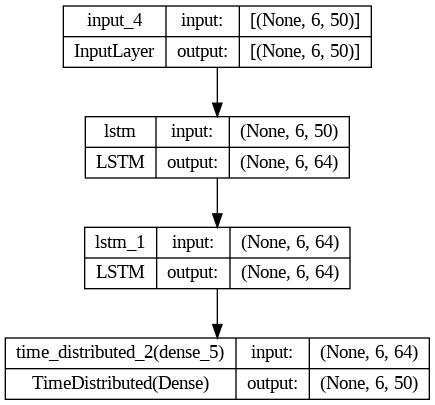

In [ ]:
#@title Create LSTM model
numberOfUnits = 64
model_LSTM = Sequential(name='model_LSTM')
model_LSTM.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()
plot_model(model_LSTM,show_shapes=True)

In [ ]:
#@title Train and Evaluate LSTM model
trained_model_lstm, history_lstm = train_test(model_LSTM, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 12s - loss: 3.1424 - accuracy: 0.1571 - val_loss: 2.8620 - val_accuracy: 0.1819 - 12s/epoch - 21ms/step
Epoch 2/100
563/563 - 6s - loss: 2.7887 - accuracy: 0.1858 - val_loss: 2.7498 - val_accuracy: 0.1911 - 6s/epoch - 11ms/step
Epoch 3/100
563/563 - 6s - loss: 2.7009 - accuracy: 0.2001 - val_loss: 2.6696 - val_accuracy: 0.2113 - 6s/epoch - 10ms/step
Epoch 4/100
563/563 - 7s - loss: 2.6052 - accuracy: 0.2363 - val_loss: 2.5672 - val_accuracy: 0.2660 - 7s/epoch - 12ms/step
Epoch 5/100
563/563 - 6s - loss: 2.4725 - accuracy: 0.3100 - val_loss: 2.4305 - val_accuracy: 0.3397 - 6s/epoch - 10ms/step
Epoch 6/100
563/563 - 6s - loss: 2.3331 - accuracy: 0.3808 - val_loss: 2.2901 - val_accuracy: 0.4001 - 6s/epoch - 11ms/step
Epoch 7/100
563/563 - 6s - loss: 2.2190 - accuracy: 0.4295 - val_loss: 2.1945 - val_accuracy: 0.4361 - 6s/epoch - 10ms/step
Epoch 8/100
563/56

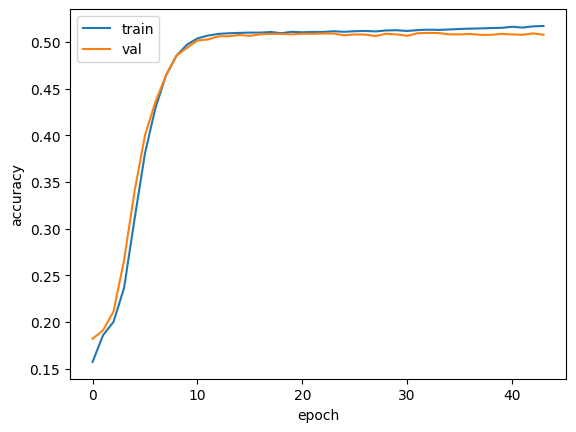

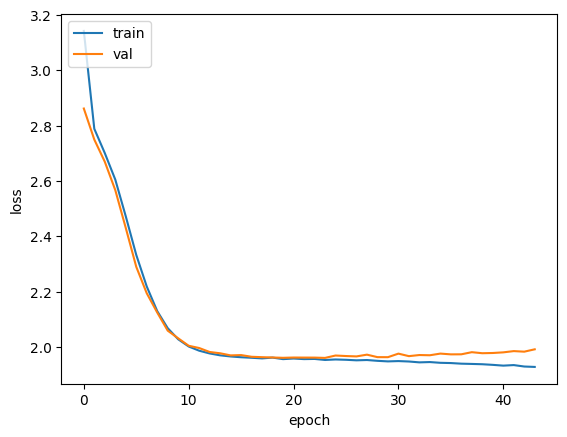

In [ ]:
#@title Visualize training and validation LSTM model
visualize_history(history_lstm)

In [ ]:
#@title Check random samples LSTM model
check_samples(trained_model_lstm, X_test, y_test, word_array, num_samples=10)

Input: trumpet island green broccoli island potato, Expected: potato island broccoli green island trumpet, Predicted: trumpet Sydney lamp green island trumpet False
Input: Sydney London bird Sydney Paris Tokyo, Expected: Tokyo Paris Sydney bird London Sydney, Predicted: Sydney Sydney rose bird London Sydney False
Input: blue Sydney car computer strawberry tomato, Expected: tomato strawberry computer car Sydney blue, Predicted: blue piano cherry car Sydney blue False
Input: bicycle desert strawberry motorcycle piano desert, Expected: desert piano motorcycle strawberry desert bicycle, Predicted: bicycle Sydney book strawberry desert bicycle False
Input: Paris London violin Sydney green cucumber, Expected: cucumber green Sydney violin London Paris, Predicted: banana tulip banana violin London Paris False
Input: broccoli guitar desert car daisy flute, Expected: flute daisy car desert guitar broccoli, Predicted: broccoli strawberry broccoli desert guitar broccoli False
Input: green motorcyc

#3. Information Sharing in RNN Layers

#3.1. LSTM model - Only last hidden state



Model: "model_LSTM_with_last_hidden"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 repeat_vector (RepeatVecto  (None, 6, 64)             0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 6, 64)             0         
 tor)                                                            
                                                                 
 dense_6 (Dense)             (None, 6, 50)             3250      
                                                                 
Total params: 65714 (256.70 KB)
Trainab

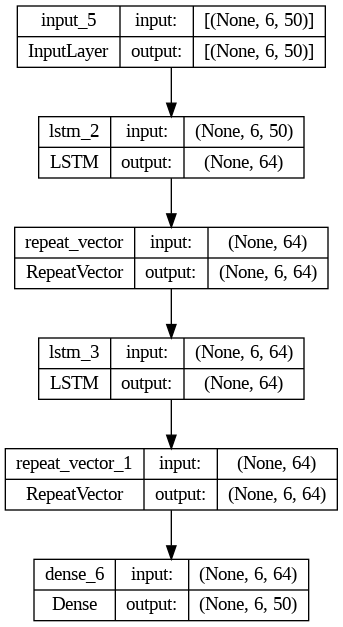

In [ ]:
#@title Create LSTM model with only last hidden state
numberOfUnits = 64
model_LSTM_with_last_hidden = Sequential(name='model_LSTM_with_last_hidden')
model_LSTM_with_last_hidden.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(Dense(n_features, activation='softmax'))


model_LSTM_with_last_hidden.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden.summary()
plot_model(model_LSTM_with_last_hidden,show_shapes=True)

In [ ]:
#@title Train and Evaluate LSTM model with only last hidden state
trained_model_with_last_hidden, history_with_last_hidden = train_test(model_LSTM_with_last_hidden, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 12s - loss: 2.8147 - accuracy: 0.1861 - val_loss: 2.4015 - val_accuracy: 0.2121 - 12s/epoch - 21ms/step
Epoch 2/100
563/563 - 6s - loss: 2.2699 - accuracy: 0.2121 - val_loss: 2.1891 - val_accuracy: 0.2128 - 6s/epoch - 11ms/step
Epoch 3/100
563/563 - 5s - loss: 2.1123 - accuracy: 0.2124 - val_loss: 2.0694 - val_accuracy: 0.2130 - 5s/epoch - 9ms/step
Epoch 4/100
563/563 - 6s - loss: 2.0195 - accuracy: 0.2124 - val_loss: 1.9967 - val_accuracy: 0.2126 - 6s/epoch - 11ms/step
Epoch 5/100
563/563 - 6s - loss: 1.9587 - accuracy: 0.2122 - val_loss: 1.9452 - val_accuracy: 0.2128 - 6s/epoch - 10ms/step
Epoch 6/100
563/563 - 6s - loss: 1.9161 - accuracy: 0.2119 - val_loss: 1.9099 - val_accuracy: 0.2128 - 6s/epoch - 11ms/step
Epoch 7/100
563/563 - 6s - loss: 1.8849 - accuracy: 0.2117 - val_loss: 1.8827 - val_accuracy: 0.2119 - 6s/epoch - 10ms/step
Epoch 8/100
563/563

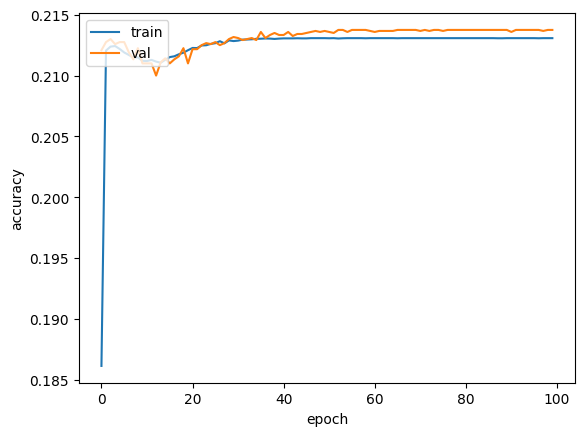

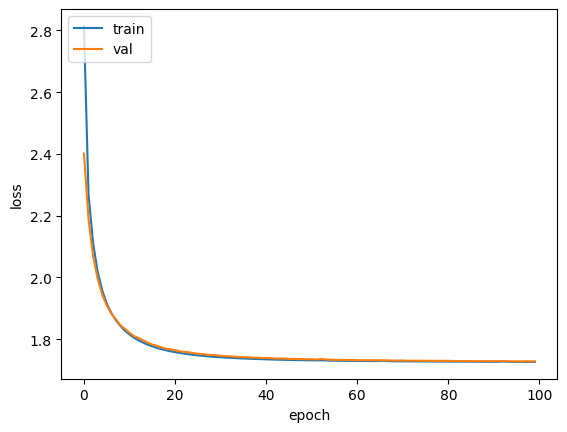

In [ ]:
#@title Visualize training and validation LSTM model with only last hidden state
visualize_history(history_with_last_hidden)

In [ ]:
#@title Check random samples LSTM model with only last hidden state
check_samples(trained_model_with_last_hidden, X_test, y_test, word_array, num_samples=10)

Input: motorcycle lion Sydney yellow car green, Expected: green car yellow Sydney lion motorcycle, Predicted: car car car car car car False
Input: blue piano piano dog violin blue, Expected: blue violin dog piano piano blue, Predicted: blue blue blue blue blue blue False
Input: mountain strawberry lily orange Sydney apple, Expected: apple Sydney orange lily strawberry mountain, Predicted: Sydney Sydney Sydney Sydney Sydney Sydney False
Input: Sydney desert computer table banana London, Expected: London banana table computer desert Sydney, Predicted: computer computer computer computer computer computer False
Input: rose violin lamp mountain trumpet lamp, Expected: lamp trumpet mountain lamp violin rose, Predicted: lamp lamp lamp lamp lamp lamp False
Input: daisy park apple desert tomato green, Expected: green tomato desert apple park daisy, Predicted: desert desert desert desert desert desert False
Input: Paris Colombo bus mountain trumpet dog, Expected: dog trumpet mountain bus Colomb

#3.2. LSTM model - Last hidden state and last cell state

Model: "model_LSTM_with_last_hidden_and_last_cell"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 6, 50)]              0         []                            
                                                                                                  
 lstm_4 (LSTM)               [(None, 64),                 29440     ['input_6[0][0]']             
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 6, 64)                0         ['lstm_4[0][0]']              
 tor)                                                     

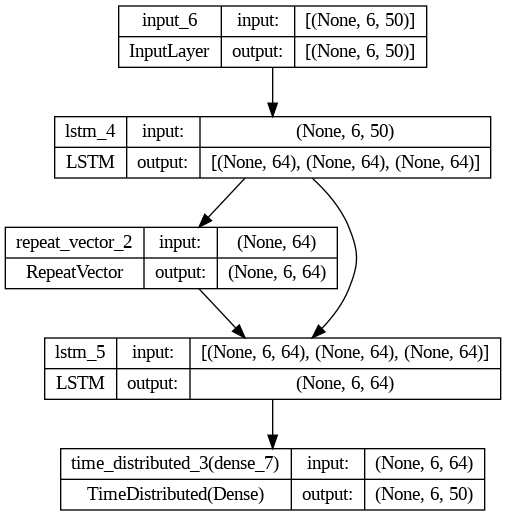

In [ ]:
#@title Create LSTM model with last hidden state and last cell state
numberOfUnits = 64
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_state=True)
LSTM_output, state_h, state_c = lstm1(input)
states = [state_h, state_c]

repeat=RepeatVector(n_timesteps_in)
LSTM_output = repeat(LSTM_output)

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(LSTM_output,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_last_hidden_and_last_cell = Model(input,output,name='model_LSTM_with_last_hidden_and_last_cell')
model_LSTM_with_last_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_last_hidden_and_last_cell,show_shapes=True)

In [ ]:
#@title Train and Evaluate LSTM model with last hidden state and last cell state
trained_model_with_last_hidden_and_last_cell, history_with_last_hidden_and_last_cell = train_test(model_LSTM_with_last_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 12s - loss: 2.8352 - accuracy: 0.1956 - val_loss: 2.3725 - val_accuracy: 0.2366 - 12s/epoch - 22ms/step
Epoch 2/100
563/563 - 5s - loss: 2.1581 - accuracy: 0.2847 - val_loss: 1.9487 - val_accuracy: 0.3465 - 5s/epoch - 9ms/step
Epoch 3/100
563/563 - 7s - loss: 1.7528 - accuracy: 0.4029 - val_loss: 1.6092 - val_accuracy: 0.4441 - 7s/epoch - 12ms/step
Epoch 4/100
563/563 - 6s - loss: 1.4407 - accuracy: 0.5011 - val_loss: 1.3426 - val_accuracy: 0.5340 - 6s/epoch - 10ms/step
Epoch 5/100
563/563 - 6s - loss: 1.1902 - accuracy: 0.5925 - val_loss: 1.1122 - val_accuracy: 0.6248 - 6s/epoch - 11ms/step
Epoch 6/100
563/563 - 6s - loss: 0.9752 - accuracy: 0.6738 - val_loss: 0.9188 - val_accuracy: 0.6957 - 6s/epoch - 10ms/step
Epoch 7/100
563/563 - 6s - loss: 0.7987 - accuracy: 0.7412 - val_loss: 0.7652 - val_accuracy: 0.7518 - 6s/epoch - 12ms/step
Epoch 8/100
563/563

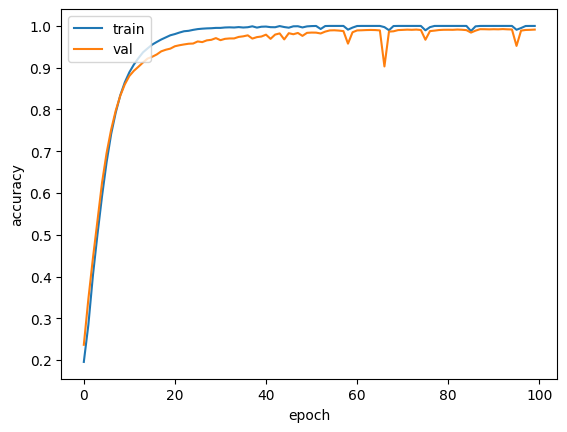

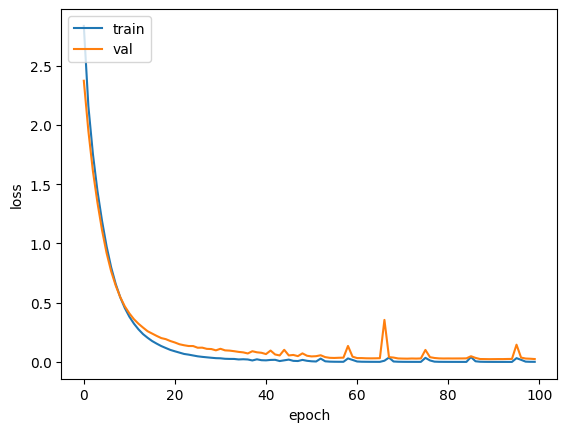

In [ ]:
#@title Visualize training and validation LSTM model with last hidden state and last cell state
visualize_history(history_with_last_hidden_and_last_cell)

In [ ]:
#@title Check random samples LSTM model with last hidden state and last cell state
check_samples(trained_model_with_last_hidden_and_last_cell, X_test, y_test, word_array, num_samples=10)

Input: blue sunflower flute book computer London, Expected: London computer book flute sunflower blue, Predicted: London computer book flute sunflower blue True
Input: Colombo bird dog sunflower violin desert, Expected: desert violin sunflower dog bird Colombo, Predicted: desert violin sunflower dog bird Colombo True
Input: tomato red Paris book lamp guitar, Expected: guitar lamp book Paris red tomato, Predicted: guitar lamp book Paris red tomato True
Input: London lamp blue book island apple, Expected: apple island book blue lamp London, Predicted: apple island book blue lamp London True
Input: blue Sydney car computer strawberry tomato, Expected: tomato strawberry computer car Sydney blue, Predicted: tomato strawberry computer tulip Sydney blue False
Input: park cherry London cucumber carrot park, Expected: park carrot cucumber London cherry park, Predicted: park carrot cucumber London cherry park True
Input: island Sydney apple yellow green Tokyo, Expected: Tokyo green yellow apple 

#3.3. LSTM model - All hidden states and last cell state

Model: "model_LSTM_with_all_hidden_and_last_cell"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 6, 50)]              0         []                            
                                                                                                  
 lstm_6 (LSTM)               [(None, 6, 64),              29440     ['input_7[0][0]']             
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 lstm_7 (LSTM)               (None, 6, 64)                33024     ['lstm_6[0][0]',              
                                                           

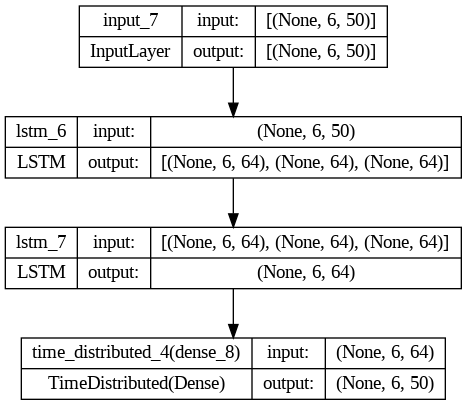

In [ ]:
#@title Create LSTM model with all hidden states and last cell state
numberOfUnits = 64
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input)
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_all_hidden_and_last_cell = Model(input,output, name='model_LSTM_with_all_hidden_and_last_cell')
model_LSTM_with_all_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_all_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_all_hidden_and_last_cell,show_shapes=True)

In [ ]:
#@title Train and Evaluate LSTM model with all hidden states and last cell state
trained_model_with_all_hidden_and_last_cell, history_with_all_hidden_and_last_cell = train_test(model_LSTM_with_all_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 11s - loss: 2.8504 - accuracy: 0.1940 - val_loss: 2.3644 - val_accuracy: 0.2447 - 11s/epoch - 20ms/step
Epoch 2/100
563/563 - 6s - loss: 2.1039 - accuracy: 0.3012 - val_loss: 1.8601 - val_accuracy: 0.3648 - 6s/epoch - 11ms/step
Epoch 3/100
563/563 - 5s - loss: 1.6522 - accuracy: 0.4235 - val_loss: 1.5055 - val_accuracy: 0.4757 - 5s/epoch - 9ms/step
Epoch 4/100
563/563 - 6s - loss: 1.3336 - accuracy: 0.5303 - val_loss: 1.2410 - val_accuracy: 0.5721 - 6s/epoch - 11ms/step
Epoch 5/100
563/563 - 5s - loss: 1.0753 - accuracy: 0.6302 - val_loss: 0.9984 - val_accuracy: 0.6643 - 5s/epoch - 10ms/step
Epoch 6/100
563/563 - 6s - loss: 0.8587 - accuracy: 0.7169 - val_loss: 0.8012 - val_accuracy: 0.7427 - 6s/epoch - 11ms/step
Epoch 7/100
563/563 - 5s - loss: 0.6867 - accuracy: 0.7841 - val_loss: 0.6598 - val_accuracy: 0.7890 - 5s/epoch - 9ms/step
Epoch 8/100
563/563 

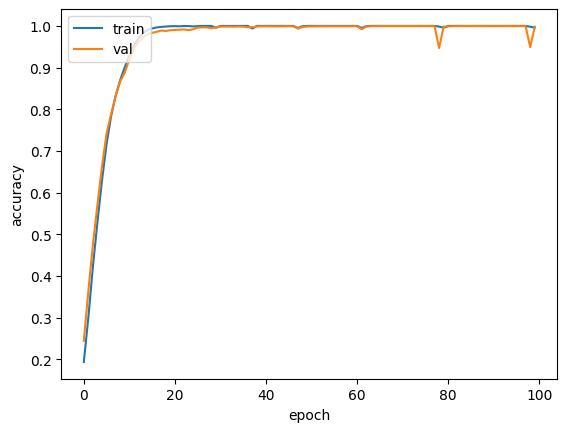

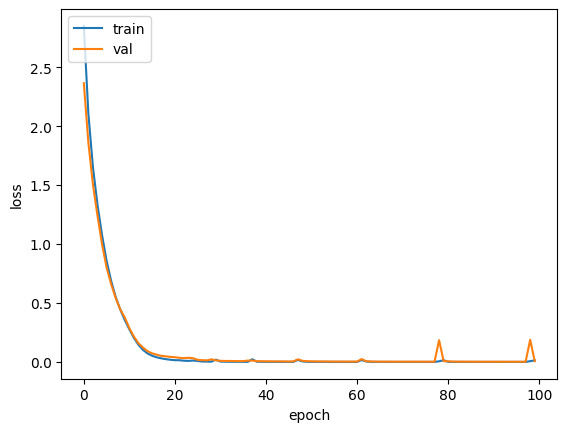

In [ ]:
#@title Visualize training and validation LSTM model with all hidden states and last cell state
visualize_history(history_with_all_hidden_and_last_cell)

In [ ]:
#@title Check random samples LSTM model with all hidden states and last cell state
check_samples(trained_model_with_all_hidden_and_last_cell, X_test, y_test, word_array, num_samples=10)

Input: trumpet purple yellow yellow tulip book, Expected: book tulip yellow yellow purple trumpet, Predicted: book tulip yellow yellow purple trumpet True
Input: computer motorcycle motorcycle banana blue yellow, Expected: yellow blue banana motorcycle motorcycle computer, Predicted: yellow blue banana motorcycle motorcycle computer True
Input: rose trumpet bicycle book strawberry broccoli, Expected: broccoli strawberry book bicycle trumpet rose, Predicted: broccoli strawberry book bicycle trumpet rose True
Input: car strawberry violin broccoli Tokyo carrot, Expected: carrot Tokyo broccoli violin strawberry car, Predicted: carrot Tokyo broccoli violin strawberry car True
Input: Colombo cherry London train tomato train, Expected: train tomato train London cherry Colombo, Predicted: train tomato train London cherry Colombo True
Input: purple Paris banana elephant computer violin, Expected: violin computer elephant banana Paris purple, Predicted: violin computer elephant banana Paris purp

#Reference
1. https://www.muratkarakaya.net/2022/11/seq2seq-learning-tutorial-series.html
2. https://deeplearningmath.org/sequence-models.html
